# Figure 10: Environmental biases in proxy values
This notebook can be used to: 
- Generate/load and plot the synthetic d13C and age constraint data (as in Fig. 10a)
- Build and sample the inference model using different offset parameterizations (Experiment 1 and Experiment 2 in Fig. 10)
- Load the inference results from the model run used to produce Fig. 10b-e
- Visualize the results using functions from `stratmc.plotting`
- Quantify signal recovery for each experiment
- Reproduce Fig. 10 using the provided inference results

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

import stratmc

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]
rcParams.update({"text.usetex": False})

import warnings

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde, norm

warnings.simplefilter(action="ignore", category=FutureWarning)

## Synthetic d13C signal and data

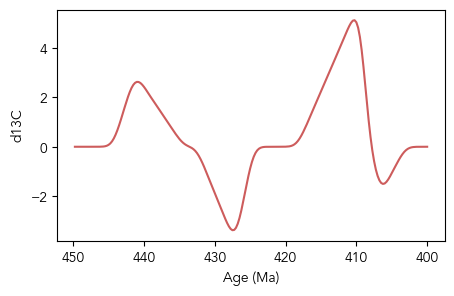

In [2]:
age_vector = np.arange(400, 450, 0.25)
amplitude = [3, -4, 6, -2]
d13c_signal = stratmc.synthetics.make_excursion(
    age_vector,
    amplitude,
    excursion_duration=[10, 8, 10, 5],
    rising_time=[0.3, 0.7, 0.9, 0.3],
    smooth=True,
    smoothing_factor=2,
    rate_offset=True,
    seed=7,
)

d13c_signal = gaussian(np.flip(d13c_signal), 3)

signal_dict = {}
signal_dict["d13c"] = d13c_signal

proxies = ["d13c"]

fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color="indianred")

ax.invert_xaxis()
ax.set_xlabel("Age (Ma)")
ax.set_ylabel("d13C");

In [3]:
# load unmodified observations (run the cells in the next section to modify)
# sample_df = stratmc.data.load_object('data/Fig5_synthetic_sample_df_unmodified')
# ages_df = stratmc.data.load_object('data/Fig5_synthetic_ages_df_unmodified')

# or load the modified observations (in this case, skip the next section)
sample_df = stratmc.data.load_object("data/Fig10_local_bias_sample_df")
ages_df = stratmc.data.load_object("data/Fig10_local_bias_ages_df")

sections = np.unique(sample_df["section"].values)

## Modify observations for experiments
**Only run the code in this section if you loaded the unmodified d13C observations in `Fig5_synthetic_sample_df_unmodified.pkl` and `Fig5_synthetic_ages_df_unmodified.pkl`.** The observations in `Fig10_local_gradients_sample_df.pkl` and `Fig10_local_gradients_ages_df.pkl` have already been modified.

### Modify d13C data to reflect local biases
Creates new lithostratigraphy for each section, then shifts the d13C observations in each environment using a prescribed offset distribution 

In [36]:
np.random.seed(0)
sample_df["d13c_original"] = sample_df["d13c"].values
sample_df["offset_group_d13c"] = ""
sample_df["facies"] = ""
sample_df["offset_value"] = np.nan

## section 1
# start sabkha
# tidal flats migrate --> now have terrestrial influence
section_1_offset_groups = 18 * ["sabkha"] + 12 * ["nearshore"]
section_1_facies_groups = (
    2 * ["grainstone"]
    + 3 * ["packstone"]
    + 3 * ["grainstone"]
    + 3 * ["wackestone"]
    + 3 * ["packstone"]
    + 4 * ["grainstone"]
    + 3 * ["packstone"]
    + 5 * ["grainstone"]
    + 2 * ["packstone"]
    + 2 * ["wackestone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "1"] = section_1_offset_groups
sample_df["facies"][sample_df["section"] == "1"] = section_1_facies_groups


## section 2
# start depleted (close to terrestrial source)
# terrestrial source migrates, now slightly elevated (subtidal)
# cap with very elevated (restricted sabkha)
section_2_offset_groups = 8 * ["nearshore"] + 12 * ["subtidal"] + 10 * ["sabkha"]
section_2_facies_groups = (
    4 * ["packstone"]
    + 4 * ["grainstone"]
    + 4 * ["mudstone"]
    + 3 * ["wackestone"]
    + 2 * ["packstone"]
    + 3 * ["wackestone"]
    + 4 * ["packstone"]
    + 6 * ["grainstone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "2"] = section_2_offset_groups
sample_df["facies"][sample_df["section"] == "2"] = section_2_facies_groups


## section 3
# start elevated (shallow subtidal)
# then shift to depleted as water depth shallows and terrestrial source approaches
section_3_offset_groups = 17 * ["subtidal"] + 13 * ["nearshore"]
section_3_facies_groups = (
    3 * ["mudstone"]
    + 4 * ["wackestone"]
    + 3 * ["packstone"]
    + 3 * ["mudstone"]
    + 4 * ["wackestone"]
    + 4 * ["packstone"]
    + 3 * ["grainstone"]
    + 2 * ["packstone"]
    + 4 * ["grainstone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "3"] = section_3_offset_groups
sample_df["facies"][sample_df["section"] == "3"] = section_3_facies_groups

## section 4
# start sabkha at base, shallow upward to subtidal
section_4_offset_groups = 11 * ["sabkha"] + 14 * ["subtidal"]
section_4_facies_groups = (
    4 * ["packstone"]
    + 3 * ["grainstone"]
    + 3 * ["packstone"]
    + 1 * ["grainstone"]
    + 3 * ["mudstone"]
    + 3 * ["wackestone"]
    + 2 * ["packstone"]
    + 2 * ["mudstone"]
    + 4 * ["wackestone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "4"] = section_4_offset_groups
sample_df["facies"][sample_df["section"] == "4"] = section_4_facies_groups

## section 5
# start open-marine
# shallow upward to subtidal
section_5_offset_groups = 18 * ["open-marine"] + 8 * ["subtidal"]
section_5_facies_groups = (
    5 * ["mudstone"]
    + 3 * ["wackestone"]
    + 4 * ["mudstone"]
    + 2 * ["wackestone"]
    + 4 * ["mudstone"]
    + 4 * ["wackestone"]
    + 4 * ["packstone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "5"] = section_5_offset_groups
sample_df["facies"][sample_df["section"] == "5"] = section_5_facies_groups


## section 6
# just open-marine
section_6_offset_groups = 30 * ["open-marine"]
section_6_facies_groups = (
    3 * ["mudstone"]
    + 5 * ["wackestone"]
    + 5 * ["mudstone"]
    + 2 * ["wackestone"]
    + 11 * ["mudstone"]
    + 4 * ["wackestone"]
)
sample_df["offset_group_d13c"][sample_df["section"] == "6"] = section_6_offset_groups
sample_df["facies"][sample_df["section"] == "6"] = section_6_facies_groups

sample_df["offset_value"][sample_df["offset_group_d13c"] == "nearshore"] = (
    np.random.normal(
        -3,
        1,
        size=len(sample_df[sample_df["offset_group_d13c"] == "nearshore"]["d13c"]),
    )
)
sample_df["offset_value"][sample_df["offset_group_d13c"] == "subtidal"] = (
    np.random.normal(
        3, 1, size=len(sample_df[sample_df["offset_group_d13c"] == "subtidal"]["d13c"])
    )
)
sample_df["offset_value"][sample_df["offset_group_d13c"] == "open-marine"] = (
    np.random.normal(
        0,
        0.5,
        size=len(sample_df[sample_df["offset_group_d13c"] == "open-marine"]["d13c"]),
    )
)
sample_df["offset_value"][sample_df["offset_group_d13c"] == "sabkha"] = (
    np.random.normal(
        15, 2, size=len(sample_df[sample_df["offset_group_d13c"] == "sabkha"]["d13c"])
    )
)


sample_df["d13c"][sample_df["offset_group_d13c"] == "nearshore"] += sample_df[
    "offset_value"
][sample_df["offset_group_d13c"] == "nearshore"]
sample_df["d13c"][sample_df["offset_group_d13c"] == "subtidal"] += sample_df[
    "offset_value"
][sample_df["offset_group_d13c"] == "subtidal"]
sample_df["d13c"][sample_df["offset_group_d13c"] == "open-marine"] += sample_df[
    "offset_value"
][sample_df["offset_group_d13c"] == "open-marine"]
sample_df["d13c"][sample_df["offset_group_d13c"] == "sabkha"] += sample_df[
    "offset_value"
][sample_df["offset_group_d13c"] == "sabkha"]

### Plot the true offset for each environment (Fig. 9b)

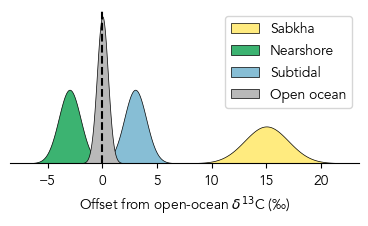

In [37]:
xs = np.linspace(-7, 22, 500)

env_offset = {}
env_offset["nearshore"] = -3
env_offset["sabkha"] = 15
env_offset["open-marine"] = 0
env_offset["subtidal"] = 3

nearshore_pdf = norm.pdf(xs, loc=-3, scale=1)
sabkha_pdf = norm.pdf(xs, loc=15, scale=2)
open_pdf = norm.pdf(xs, loc=0, scale=0.5)
subtidal_pdf = norm.pdf(xs, loc=3, scale=1)

fs = 10
fig = plt.figure(figsize=(4.5, 2))
ax = fig.gca()

ax.fill_between(xs, sabkha_pdf, color="#FFEB7F", edgecolor="k", lw=0.5, label="Sabkha")
ax.fill_between(
    xs, nearshore_pdf, color="mediumseagreen", edgecolor="k", lw=0.5, label="Nearshore"
)
ax.fill_between(
    xs, subtidal_pdf, color="#87BED5", edgecolor="k", lw=0.5, label="Subtidal"
)
ax.fill_between(
    xs, open_pdf, color="#B9B9B9", edgecolor="k", lw=0.5, label="Open ocean"
)

ax.set_xlabel(
    "Offset from open-ocean $\delta^{13}$C (‰)", fontsize=fs
)  # $\delta^{13}$C
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(direction="out", labelsize=fs)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(False)

yl = ax.get_ylim()
ax.set_ylim(0, yl[1])

ax.axvline(0, color="k", linestyle="dashed")

ax.legend()

### add a depositional age at 426 Ma to each section

In [38]:
dep_age = {
    "section": ["1"],
    "height": [23.57],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

dep_age = {
    "section": ["2"],
    "height": [5.65],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

dep_age = {
    "section": ["3"],
    "height": [14.15],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

dep_age = {
    "section": ["4"],
    "height": [4.7],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

dep_age = {
    "section": ["5"],
    "height": [5.75],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

dep_age = {
    "section": ["6"],
    "height": [6.6],
    "age": [426],
    "age_std": [1.5],
    "distribution_type": "Normal",
    "param_1": [np.nan],
    "param_2": [np.nan],
    "param_1_name": [np.nan],
    "param_2_name": [np.nan],
    "shared?": False,
    "intermediate detrital?": False,
    "intermediate intrusive?": False,
    "name": [np.nan],
    "Exclude?": False,
}

ages_df = pd.concat([ages_df, pd.DataFrame.from_dict(dep_age)], ignore_index=True)

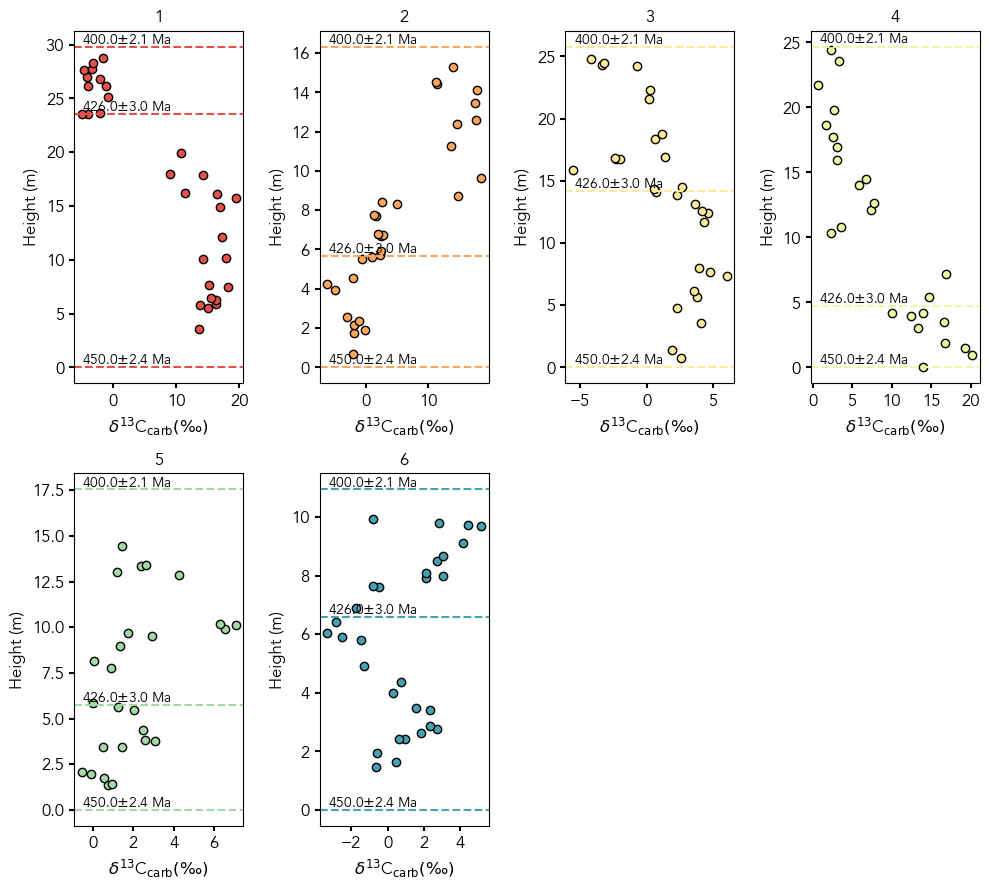

In [39]:
# check proxy data and age constraints with proxy_strat
fig = stratmc.plotting.proxy_strat(sample_df, ages_df)

## Plot modified obervations and lithostratigraphy (Fig. 10a)

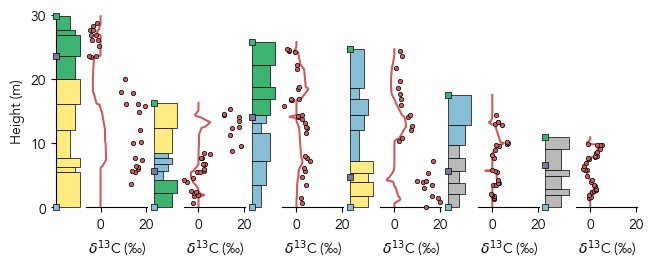

In [4]:
# strat columns
facies_colors = {}
facies_widths = {}

facies_colors["nearshore"] = "mediumseagreen"
facies_colors["subtidal"] = "#87BED5"
facies_colors["open-marine"] = "#B9B9B9"
facies_colors["sabkha"] = "#FFEB7F"

facies_widths["grainstone"] = 1.25
facies_widths["packstone"] = 1
facies_widths["mudstone"] = 0.5
facies_widths["wackestone"] = 0.75

fs = 10

widths = [0.4, 1] * 6

fig, ax = plt.subplots(
    1,
    2 * len(sections),
    figsize=(7.5, 2.5),
    sharey=True,
    gridspec_kw={"width_ratios": widths},
)

for j in np.arange(len(sections)):
    section = sections[j]

    section_ages_df = ages_df[
        (ages_df["section"] == section)
        & (~np.isnan(ages_df["age"]))
        & (~ages_df["intermediate detrital?"])
    ]
    section_df = sample_df[sample_df["section"] == section]

    sec_sample_ages = sample_df[sample_df["section"] == section]["age"].values
    sec_sample_heights = sample_df[sample_df["section"] == section]["height"].values

    sec_radio_ages = section_ages_df["age"].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df["age"]])

    heights_comb = np.concatenate([section_ages_df["height"], section_df["height"]])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    d13c_section_interp = np.interp(sec_ages_comb, age_vector, d13c_signal)

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[j * 2 + 1].plot(d13c_section_interp, new_heights, c="indianred", zorder=0)

    section_df = sample_df[sample_df["section"] == section]
    section_ages_df = ages_df[ages_df["section"] == section]
    section_ages_df = section_ages_df[~section_ages_df["Exclude?"]]

    switch_bools = section_df["facies"][:-1].values != section_df["facies"][1:].values
    switch_idx = np.where(switch_bools)[0]
    switch_idx = np.concatenate(
        [np.array([0]), switch_idx, np.array([len(section_df["facies"].values) - 1])]
    )

    total_h = np.max(section_df["height"].values)
    for i in np.arange(switch_idx.shape[0] - 1):
        facies = section_df["facies"].values[switch_idx[i] + 1]
        environment = section_df["offset_group_d13c"].values[switch_idx[i] + 1]
        height = (
            section_df["height"].values[switch_idx[i + 1]]
            - section_df["height"].values[switch_idx[i]]
        )

        current_base = section_df["height"].values[switch_idx[i]]
        if i == 0:
            current_base = 0

            height += section_df["height"].values[0]

        if i == switch_idx.shape[0] - 2:
            height += np.max(section_ages_df["height"]) - np.max(section_df["height"])

        ax[j * 2].barh(
            y=current_base,
            width=facies_widths[facies],
            height=height,
            linewidth=0.5,
            edgecolor="k",
            align="edge",
            color=facies_colors[environment],
            clip_on=False,
        )

    section_ages_df = ages_df[ages_df["section"] == section]

    for k in np.arange(section_ages_df.shape[0]):
        if k == 0:  # base of sections
            age_color = "#87BED5"

        if k == section_ages_df.shape[0] - 1:  # top of sections
            age_color = "mediumseagreen"

        if list(section_ages_df.index)[k] in [1, 4, 7, 10, 13, 16]:  # shared constraint
            age_color = "#7C78A0"  #'#F4A27C' #'#FFEB7F'  # yellow

        if section_ages_df.iloc[k]["intermediate detrital?"]:
            ax[j * 2 + 1].scatter(
                0,
                section_ages_df.iloc[k]["height"],
                color=age_color,
                marker="^",
                edgecolor="k",
                s=30,
                lw=0.5,
                zorder=10,
                clip_on=False,
            )

        else:
            ax[j * 2].scatter(
                0,
                section_ages_df.iloc[k]["height"],
                color=age_color,
                edgecolor="k",
                marker="s",
                s=25,
                lw=0.5,
                zorder=10,
                clip_on=False,
            )

    ax[j * 2 + 1].scatter(
        section_df["d13c"],
        section_df["height"],
        color="indianred",
        s=10,
        edgecolor="k",
        lw=0.5,
        clip_on=False,
        zorder=10,
    )

_ = [ax[i].sharex(ax[1]) for i in [3, 5, 7, 9, 11]]
ax[0].set_ylim([0, 30])


[ax[i].set_xticks([]) for i in [0, 2, 4, 6, 8, 10]]
[ax[i].set_xlabel("$\delta^{13}$C (‰)", fontsize=fs) for i in [1, 3, 5, 7, 9, 11]]

ax[0].set_ylabel("Height (m)", fontsize=fs)

[ax[i].tick_params(direction="out", labelsize=fs) for i in np.arange(ax.shape[0])]

fig.subplots_adjust(wspace=0.15)

for i in np.arange(1, len(sections) * 2):
    for tick in ax[i].yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

for axis in ax.ravel():
    axis.set_axisbelow(True)

ax[0].set_ylim([0, np.max(ages_df["height"])])

ax[0].set_xlim([0, 1.25])

for i in [0, 2, 4, 6, 8, 10]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["left"].set_visible(False)

ax[0].spines["left"].set_visible(True)


for i in [1, 3, 5, 7, 9, 11]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(False)

ax[0].set_yticks([0, 10, 20, 30])
ax[0].set_yticklabels([0, 10, 20, 30])

for i in np.arange(1, 12):
    [t.set_color("none") for t in ax[i].yaxis.get_ticklabels()]
    ax[i].tick_params(axis="y", color="none")

## Experiment 1: Environment-dependent offset terms
Run the inference model with a unique offset term for each depositional environment. To load the results for the inferences used to produce Fig. 10b-c, skip to [Load the inference results](#Load-the-inference-results). 

In [5]:
model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=["d13c"],
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="groups",  # environmental offset groupings with default prior
    noise_type="section",  # per-section noise with default prior
)

In [ ]:
predict_ages = age_vector[:, None]

extension = "Fig10_local_bias_experiment_1"

full_trace = stratmc.inference.get_trace(
    model,
    gp,
    predict_ages,
    sample_df,
    ages_df,
    proxies=["d13c"],
    name=extension,
    chains=100,
    target_accept=0.9,
)

## Experiment 2: Per-section offset terms
Run the inference model with a unique offset term for each section. To load the results for the inference used to produce Fig. 10d, skip to [Load the inference results](#Load-the-inference-results). 

In [70]:
model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=["d13c"],
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior
    noise_type="section",  # per-section noise with default prior
)

In [ ]:
predict_ages = age_vector[:, None]

extension = "Fig10_local_bias_experiment_2"

full_trace = stratmc.inference.get_trace(
    model,
    gp,
    predict_ages,
    sample_df,
    ages_df,
    proxies=["d13c"],
    name=extension,
    chains=100,
    target_accept=0.9,
)

## Load the inference results
Load traces for Experiment 1 and Experiment 2 used to produce Fig. 10


In [25]:
full_trace_1 = stratmc.data.load_trace("traces/" + "Fig10_local_bias_experiment_1")
full_trace_2 = stratmc.data.load_trace("traces/" + "Fig10_local_bias_experiment_2")

## Plot the inference results with `stratmc.plotting`

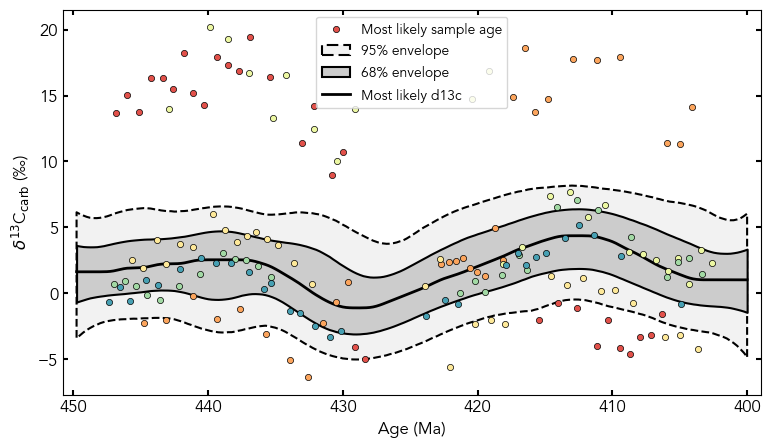

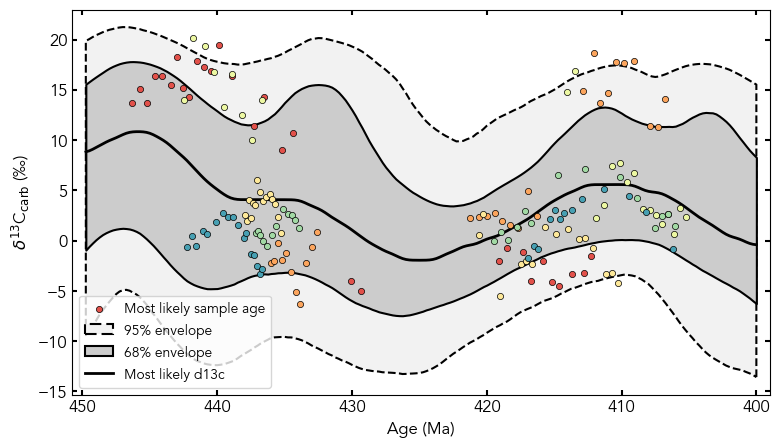

In [27]:
# Plot the proxy signal inference for each experiment
fig = stratmc.plotting.proxy_inference(sample_df, ages_df, full_trace_1, plot_data=True)
fig = stratmc.plotting.proxy_inference(sample_df, ages_df, full_trace_2, plot_data=True)

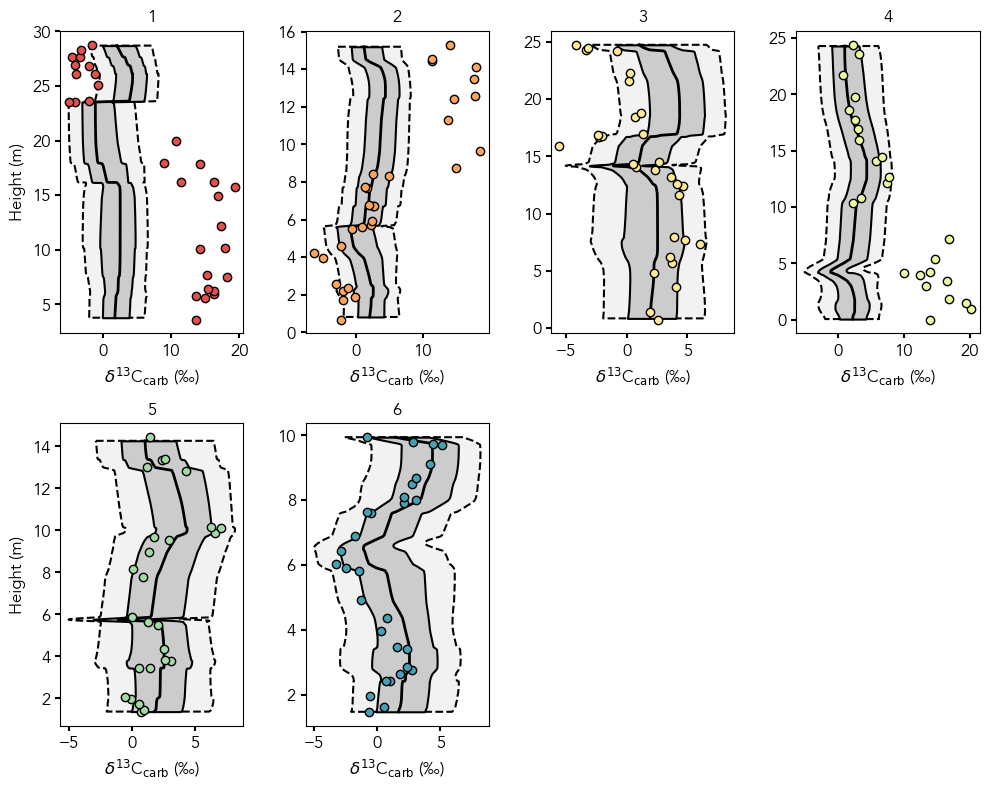

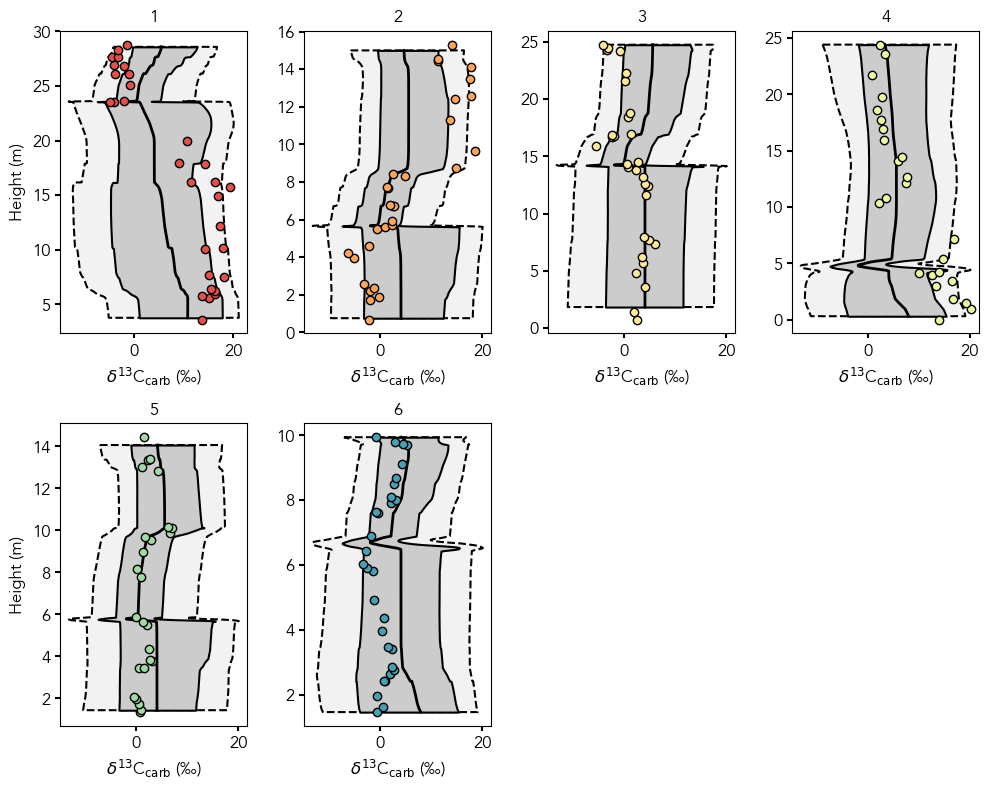

In [7]:
# For each experiment, map the proxy signal back to height in each section using the most likely posterior age models
fig = stratmc.plotting.section_proxy_signal(full_trace_1, sample_df, ages_df)
fig = stratmc.plotting.section_proxy_signal(full_trace_2, sample_df, ages_df)

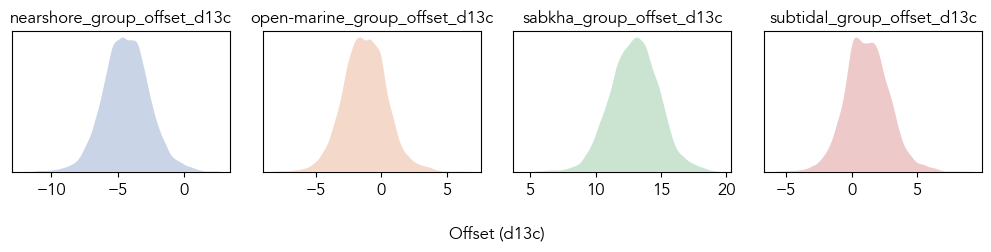

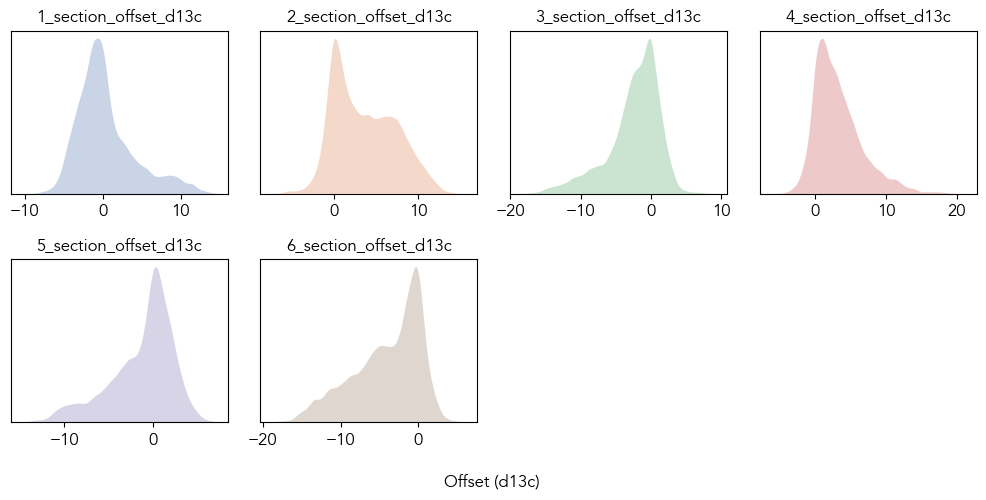

In [8]:
# Posterior offset terms for each experiment
fig = stratmc.plotting.offset_summary(full_trace_1)
fig = stratmc.plotting.offset_summary(full_trace_2)

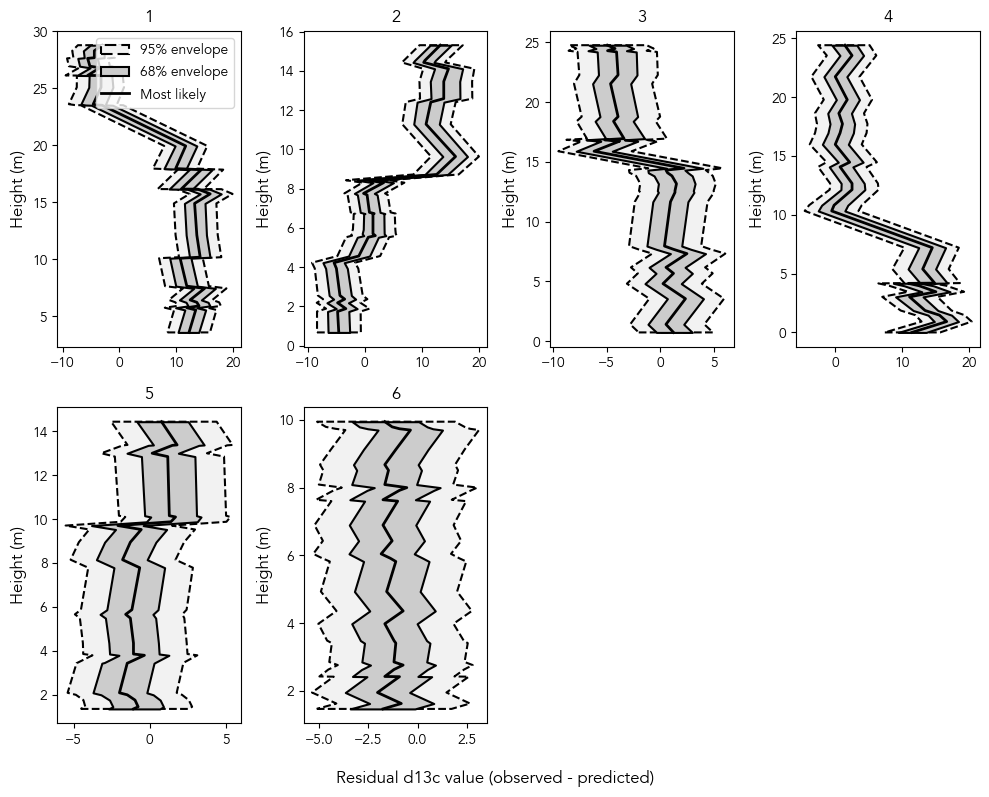

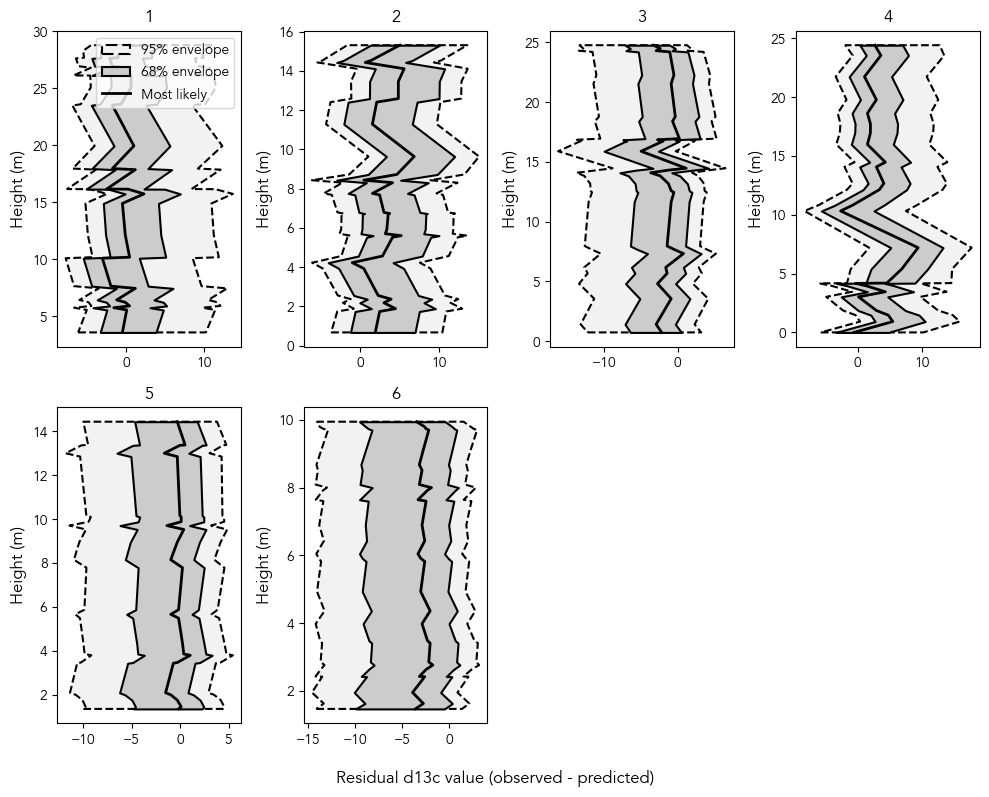

In [9]:
# plot the residuals
fig = stratmc.plotting.section_proxy_residuals(full_trace_1, sample_df)
fig = stratmc.plotting.section_proxy_residuals(full_trace_2, sample_df)

## Quantify signal recovery 
Calculate the relative likelihood of the model with environment-dependent offsets (Experiment 1) vs. per-section offsets (Experiment 2)

In [19]:
# d13C signal recovery for each experiment
signal_recovery_exp1 = stratmc.synthetics.quantify_signal_recovery(
    full_trace_1, d13c_signal, proxy="d13c"
)
signal_recovery_exp2 = stratmc.synthetics.quantify_signal_recovery(
    full_trace_2, d13c_signal, proxy="d13c"
)

# relative likelihoods
d13C_ratio_vec_exp1 = np.array(signal_recovery_exp1) / (
    np.array(signal_recovery_exp1) + np.array(signal_recovery_exp2)
)
d13C_ratio_vec_exp2 = np.array(signal_recovery_exp2) / (
    np.array(signal_recovery_exp1) + np.array(signal_recovery_exp2)
)

# average relative likelihood
d13C_probs_ratio_exp1 = np.mean(d13C_ratio_vec_exp1)
d13C_probs_ratio_exp2 = np.mean(d13C_ratio_vec_exp2)

# vector for plotting
d13C_probs = [d13C_probs_ratio_exp1, d13C_probs_ratio_exp2]

## Summary figure (Fig. 10b-e)

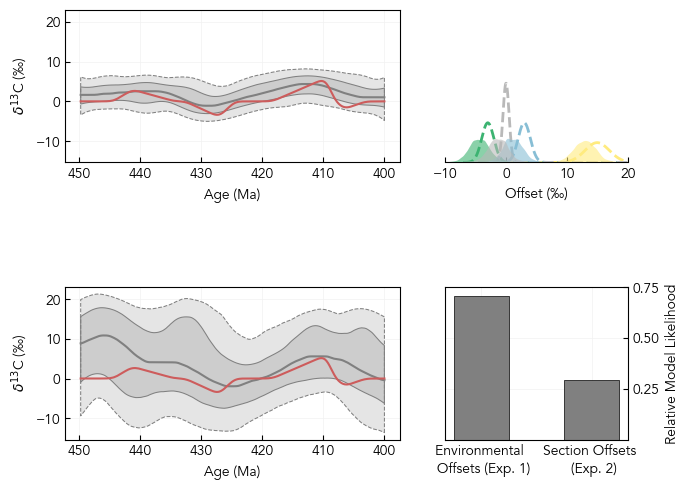

In [21]:
mosaic = """
    11111...
    11111222
    11111222
    ........
    33333444
    33333444
    33333444
    """

fs = 10
fig, ax = plt.subplot_mosaic(
    mosaic, figsize=(7, 5), sharex=False, sharey=False, constrained_layout=False
)

# posterior signal - Experiment 1
ages = full_trace_1.X_new.X_new.values
proxy_pred = az.extract(full_trace_1.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,  # 1.5
    zorder=1,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=2,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",  # "#e74c3c",
    # label='68% envelope',
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["1"].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["1"].plot(
    age_vector, d13c_signal, color="indianred", lw=1.5, label="True Signal", zorder=10
)

ax["1"].invert_xaxis()
ax["1"].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

ax["1"].set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)
ax["1"].set_xlabel("Age (Ma)", fontsize=fs)


ax["1"].set_axisbelow(True)
ax["1"].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

# posterior environmental offsets (Experiment 1)
nearshore_post = az.extract(full_trace_1.posterior)[
    "nearshore_group_offset_d13c"
].values.ravel()
subtidal_post = az.extract(full_trace_1.posterior)[
    "subtidal_group_offset_d13c"
].values.ravel()
open_post = az.extract(full_trace_1.posterior)[
    "open-marine_group_offset_d13c"
].values.ravel()
sabkha_post = az.extract(full_trace_1.posterior)[
    "sabkha_group_offset_d13c"
].values.ravel()

xs = np.linspace(-7, 22, 500)

nearshore_pdf = norm.pdf(xs, loc=-3, scale=1)
sabkha_pdf = norm.pdf(xs, loc=15, scale=2)
open_pdf = norm.pdf(xs, loc=0, scale=0.5)
subtidal_pdf = norm.pdf(xs, loc=3, scale=1)

sns.kdeplot(
    sabkha_post,
    fill=True,
    color="#FFEB7F",
    edgecolor="none",
    alpha=0.6,
    zorder=4,
    lw=1,
    label="Posterior",
    cut=0,
    ax=ax["2"],
)
sns.kdeplot(
    nearshore_post,
    fill=True,
    color="mediumseagreen",
    edgecolor="none",
    alpha=0.6,
    zorder=5,
    lw=1,
    cut=0,
    ax=ax["2"],
)
sns.kdeplot(
    subtidal_post,
    fill=True,
    color="#87BED5",
    edgecolor="none",
    alpha=0.6,
    zorder=6,
    lw=1,
    cut=0,
    ax=ax["2"],
)
sns.kdeplot(
    open_post,
    fill=True,
    color="#B9B9B9",
    edgecolor="none",
    alpha=0.6,
    zorder=7,
    lw=1,
    cut=0,
    ax=ax["2"],
)

ax["2"].plot(xs, sabkha_pdf, color="#FFEB7F", lw=2, linestyle="dashed", zorder=0)
ax["2"].plot(
    xs, nearshore_pdf, color="mediumseagreen", lw=2, linestyle="dashed", zorder=1
)
ax["2"].plot(xs, subtidal_pdf, color="#87BED5", lw=2, linestyle="dashed", zorder=2)
ax["2"].plot(xs, open_pdf, color="#B9B9B9", lw=2, linestyle="dashed", zorder=3)

ax["2"].set_xlabel("Offset (‰)", fontsize=fs)
ax["2"].set_yticks([])
ax["2"].set_ylabel("")
ax["2"].tick_params(direction="in", labelsize=fs)

ax["2"].spines["top"].set_visible(False)
ax["2"].spines["right"].set_visible(False)
ax["2"].spines["bottom"].set_visible(True)
ax["2"].spines["left"].set_visible(False)

ax["2"].set_xlim([-10, 20])

for k in "1234":
    ax[k].tick_params(direction="in", labelsize=fs)
    ax[k].set_axisbelow(True)

ax["1"].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

# posterior signal - Experiment 2
ages = full_trace_2.X_new.X_new.values
proxy_pred = az.extract(full_trace_2.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["3"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    # label='95% envelope',
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,  # 1.5
    zorder=1,
)

ax["3"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=2,
)

ax["3"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax["3"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax["3"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["3"].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["3"].plot(
    age_vector, d13c_signal, color="indianred", lw=1.5, label="True Signal", zorder=10
)

ax["3"].invert_xaxis()
ax["3"].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

ax["3"].set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)
ax["3"].set_xlabel("Age (Ma)", fontsize=fs)


ax["3"].set_axisbelow(True)
ax["3"].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)
ax["3"].set_xticks([450, 440, 430, 420, 410, 400])

ax["1"].sharex(ax["3"])
ax["1"].sharey(ax["3"])

# plot relative signal recovery
ax["4"].bar(
    [1, 2],
    d13C_probs,
    edgecolor="k",
    width=0.5,
    lw=0.5,
    color=["gray"],
    label="Age model recovery",
)

ax["4"].set_xticks(np.arange(1, 1 + len(d13C_probs)))
ax["4"].set_xticklabels(
    ["Environmental \n Offsets (Exp. 1)", "Section Offsets \n (Exp. 2)"]
)
ax["4"].set_ylabel("Relative Model Likelihood", fontsize=fs)
ax["4"].yaxis.set_label_position("right")
ax["4"].yaxis.tick_right()

ax["4"].tick_params(direction="in", labelsize=fs)
ax["4"].set_axisbelow(True)
ax["4"].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)

ax["4"].set_yticks([0.25, 0.5, 0.75])
fig.tight_layout()

fig.subplots_adjust(wspace=1.5)